In [1]:
# Dependencies
import hvplot.pandas
import requests
from requests import post
from config import client_secret, client_id
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from fuzzywuzzy import process

C:\Users\nicoo\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df_ml = pd.read_csv(
    Path("./Resources/df_ml.csv"))

In [3]:
df_ml.tail(10)

,game,reviewer_rating,positivity_ratio,first_release_date,game_modes,genres,themes,developer_Scott Cawthon,binned_developer_encoded
18806,Heroes of Dark Dungeon,6.0,2.60,2017,1,12,1,0,338
18807,Axel & Pixel,6.0,2.77,2009,1,2,17,0,338
18808,Speedball 2 HD,5.0,1.92,2013,1,14,1,0,338
18809,Return to Krondor,5.0,1.52,1998,1,12,17,0,338
18810,Redneck Kentucky and the Next Generation Chickens,8.0,20.50,2019,1,5,1,0,3
18811,Omega Agent,6.0,3.15,2016,1,5,1,0,129
18812,Time of Shadows,4.0,0.58,2009,1,12,1,0,338
18813,Drug Wars,4.0,0.42,2009,1,5,1,0,338
18814,Uncharted Waters,7.0,6.00,1990,1,12,17,0,192
18815,Sangokushi Eiketsuden,6.0,3.15,1995,1,12,17,0,192


In [4]:
# Select relevant features for clustering
#removed develop_Scott Cawthon, he's only about one or two games, not sure why this was the only one that 
#stayed in the db after cleaning
selected_features = ['reviewer_rating', 'positivity_ratio', 'first_release_date', \
                     'game_modes', 'genres', 'themes', 'binned_developer_encoded']
X = df_ml[selected_features]


In [5]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [6]:
# Determine Optimal Number of Clusters (Elbow Method)
inertia_values = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\clust

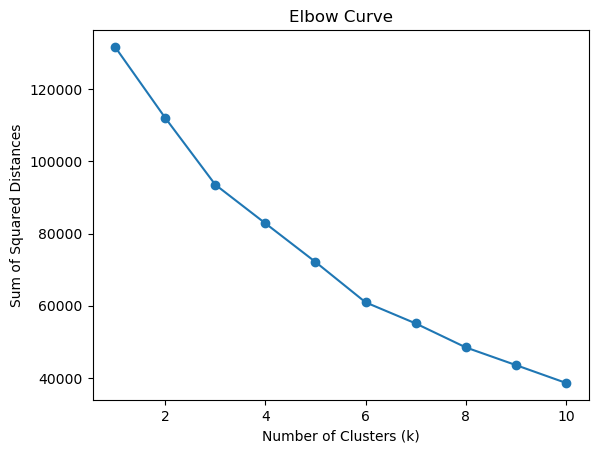

In [7]:
# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [8]:
# Based on the elbow plot
optimal_k = 8  

In [9]:
# K-means Clustering with Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_ml['Cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
# Function to get similar game names based on input game name
def get_similar_game_names(input_game, num_suggestions=3):
    input_game_lower = input_game.lower()  # Converts the input to lowercase

    try:
        # Find the row for the input game (case-insensitive)
        input_game_row = df_ml[df_ml['game'].str.lower() == input_game_lower].iloc[0]
    except IndexError:
        # If there's no exact match, suggest similar names
        all_game_names_lower = df_ml['game'].str.lower().tolist()
        similar_names = process.extract(input_game_lower, all_game_names_lower, limit=num_suggestions)
        
        suggestions = [name for name, _ in similar_names]
        
        print(f"No match found for the game '{input_game}'. You can try:")
        for suggestion in suggestions:
            print(f"- {suggestion.capitalize()}")  # Capitalizes the suggestions for better readability
        return []

    # Get features for the input game
    input_game_features = input_game_row[selected_features].values.reshape(1, -1)

    # Predict the cluster for the input game
    predicted_cluster = kmeans.predict(scaler.transform(input_game_features))[0]

    # Filter similar games in the same cluster (excluding the input game itself)
    similar_games = df_ml[(df_ml['Cluster'] == predicted_cluster) & (df_ml['game'] != input_game_row['game'])].head(num_suggestions)

    # Extract names of similar games
    similar_game_names = similar_games['game'].tolist()

    return similar_game_names

In [17]:
# Example: Input a game and get similar game names !!!!!!!limit to 3 suggestions!!!!
chosen_game = input("Please type in your desired game: ")
similar_game_names = get_similar_game_names(chosen_game, num_suggestions=3)

# Print the result
print(f"Similar Games to '{chosen_game}':")
print(similar_game_names)


Please type in your desired game: fifa
No match found for the game 'fifa'. You can try:
- Fifa 22
- Fifa 22
- Mafia gangster city
Similar Games to 'fifa':
[]


In [15]:
import hvplot.pandas
scatter_plot = df_ml.hvplot.scatter(
    x="reviewer_rating",
    y="positivity_ratio",
    by="Cluster",
    hover_cols=["game"],
    title="Scatter Plot by Game Segment - k=8"
)

# Show the plot
hvplot.show(scatter_plot)


Launching server at http://localhost:65176


C:\Users\nicoo\anaconda3\Lib\site-packages\holoviews\core\util.py:1161: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
C:\Users\nicoo\anaconda3\Lib\site-packages\holoviews\core\util.py:1161: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
C:\Users\nicoo\anaconda3\Lib\site-packages\holoviews\core\util.py:1161: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique(values)
C:\Users\nicoo\anaconda3\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

In [14]:
# export the model
import pickle

def save_model():
    # ... (same computation as before)

    # Save computed data as a binary file
    with open('computed_data.pkl', 'wb') as file:
        pickle.dump({
            'df_ml': df_ml,
            'selected_features': selected_features,
            'scaler': scaler,
            'kmeans': kmeans,
        }, file)
        
# save_model()